In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import re
import warnings
from sklearn.impute import SimpleImputer


warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
df = pd.read_csv("netflix_titles.csv")
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [5]:
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")

Dataset loaded: 8807 rows, 12 columns


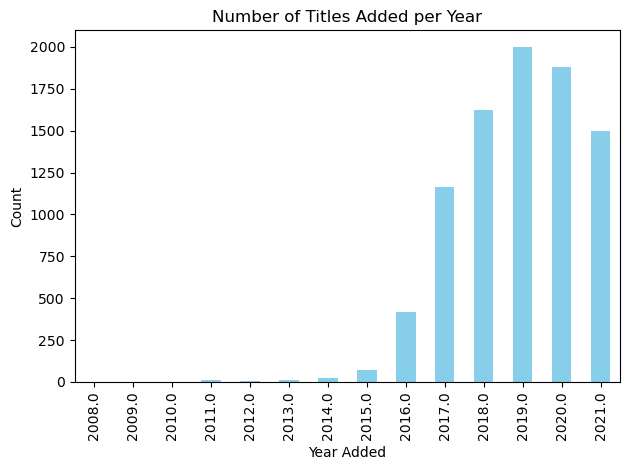

In [59]:
df['date_added'] = pd.to_datetime(df['date_added'])
df['year_added'] = df['date_added'].dt.year
df['year_added'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Number of Titles Added per Year")
plt.xlabel("Year Added")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

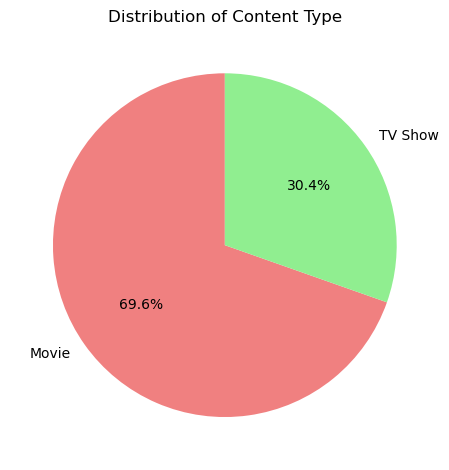

In [61]:
df['type'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightgreen'])
plt.title("Distribution of Content Type")
plt.ylabel('')
plt.tight_layout()
plt.show()

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
/var/folders/j3/d4vdhbvj4379qv9rdyn8zjym0000gn/T/ipykernel_64473/2668955374.py:1: SyntaxWarning: invalid escape sequence '\d'
  df['duration_num'] = df['duration'].str.extract('(\d+)').astype(float)


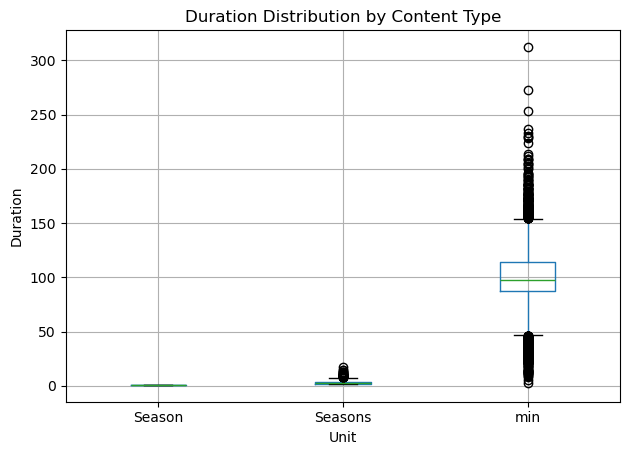

In [63]:
df['duration_num'] = df['duration'].str.extract('(\d+)').astype(float)
df['duration_unit'] = df['duration'].str.extract('([a-zA-Z]+)')

df.boxplot(column='duration_num', by='duration_unit')
plt.title("Duration Distribution by Content Type")
plt.suptitle('')
plt.xlabel("Unit")
plt.ylabel("Duration")
plt.tight_layout()
plt.show()

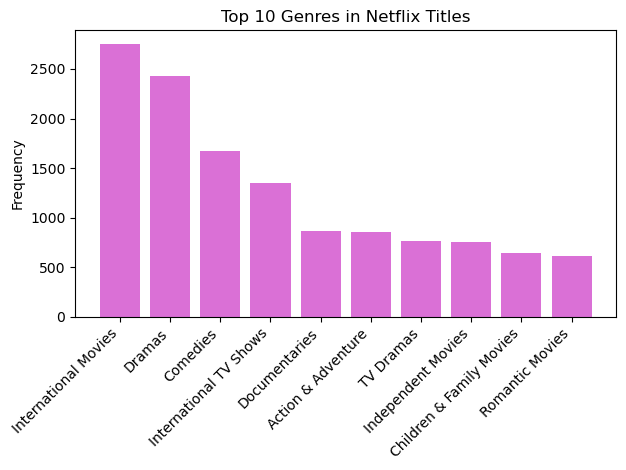

In [65]:
from collections import Counter

genre_series = df['listed_in'].dropna().str.split(', ')
genre_counts = Counter([genre for sublist in genre_series for genre in sublist])
top_genres = dict(Counter(genre_counts).most_common(10))

plt.bar(top_genres.keys(), top_genres.values(), color='orchid')
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Genres in Netflix Titles")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [7]:
df = df.dropna(subset=["release_year", "duration"])

In [9]:
def parse_duration(text: str) -> int:
    """Extract the integer part of the duration string (e.g., '90 min' → 90)."""
    if pd.isna(text):
        return np.nan
    digits = re.findall(r"\d+", text)
    return int(digits[0]) if digits else np.nan


df["duration_num"] = df["duration"].apply(parse_duration)
df = df.dropna(subset=["duration_num"])

In [11]:
df["date_added"] = pd.to_datetime(df["date_added"], errors="coerce")
df["year_added"] = df["date_added"].dt.year


In [13]:
df["year_added"] = df["year_added"].fillna(df["release_year"])


In [15]:
key_numeric = ["duration_num", "release_year", "year_added"]
df = df.dropna(subset=key_numeric)

In [17]:
df["genre_list"] = df["listed_in"].str.split(r",\s*")


In [19]:
all_genres = Counter(g for sub in df["genre_list"] for g in sub)
TOP_N = 15
popular_genres = {g for g, _ in all_genres.most_common(TOP_N)}

df["filtered_genres"] = df["genre_list"].apply(lambda lst: [g for g in lst if g in popular_genres])


In [21]:
numeric_cols = ["duration_num", "release_year", "year_added"]

In [27]:
imputer = SimpleImputer(strategy="median")
X_num = imputer.fit_transform(df[numeric_cols])

In [29]:
scaler = StandardScaler()
X_num = scaler.fit_transform(X_num)

In [31]:
mlb = MultiLabelBinarizer()
X_genre = mlb.fit_transform(df["filtered_genres"])

genre_labels = mlb.classes_.tolist()

In [55]:
encoded_genre_df = pd.DataFrame(X_genre, columns=genre_labels, index=df.index)
df = pd.concat([df, encoded_genre_df], axis=1)

In [33]:
X = np.hstack([X_num, X_genre])
print(f"Feature matrix shape: {X.shape}")

Feature matrix shape: (8804, 18)


In [35]:
silhouette = {}
print("\nSilhouette scores (2–10 clusters):")
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette[k] = score
    print(f"K={k}: {score:.3f}")

best_k = max(silhouette, key=silhouette.get)
print(f"\nBest K by silhouette: {best_k} (score={silhouette[best_k]:.3f})")



Silhouette scores (2–10 clusters):
K=2: 0.261
K=3: 0.284
K=4: 0.235
K=5: 0.205
K=6: 0.206
K=7: 0.186
K=8: 0.152
K=9: 0.147
K=10: 0.154

Best K by silhouette: 3 (score=0.284)


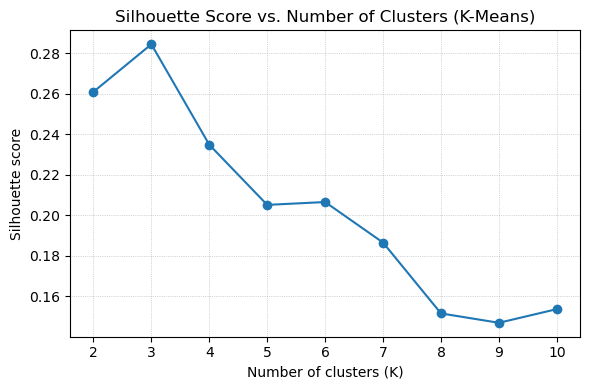

In [37]:
plt.figure(figsize=(6, 4))
plt.plot(list(silhouette.keys()), list(silhouette.values()), marker="o")
plt.title("Silhouette Score vs. Number of Clusters (K-Means)")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Silhouette score")
plt.xticks(range(2, 11))
plt.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()

In [39]:
km_final = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
df["kmeans_cluster"] = km_final.fit_predict(X)

In [41]:
print("\nBuilding hierarchical clustering linkage…")
Z = linkage(X, method="ward")


Building hierarchical clustering linkage…


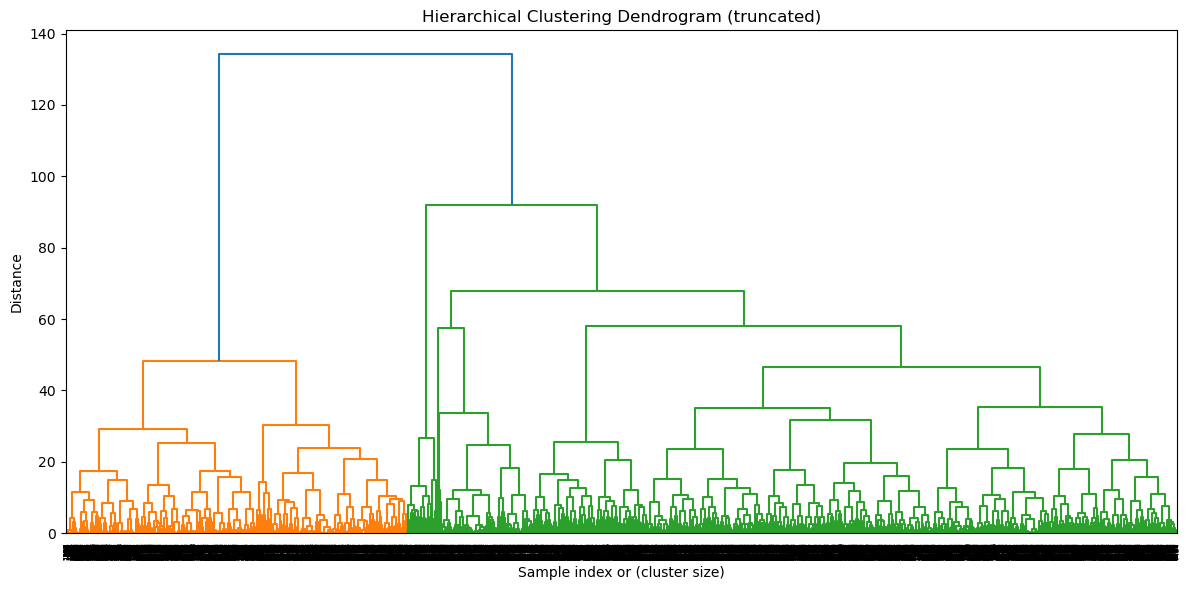

In [43]:

plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode="level", p=30)
plt.title("Hierarchical Clustering Dendrogram (truncated)")
plt.xlabel("Sample index or (cluster size)")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

In [45]:
N_HC = 6  # Adjust if needed
agg = AgglomerativeClustering(n_clusters=N_HC, linkage="ward")
df["agg_cluster"] = agg.fit_predict(X)
print(f"Assigned {N_HC} hierarchical clusters → column 'agg_cluster'.")

Assigned 6 hierarchical clusters → column 'agg_cluster'.


In [47]:
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X)
df["pc1"], df["pc2"] = coords[:, 0], coords[:, 1]

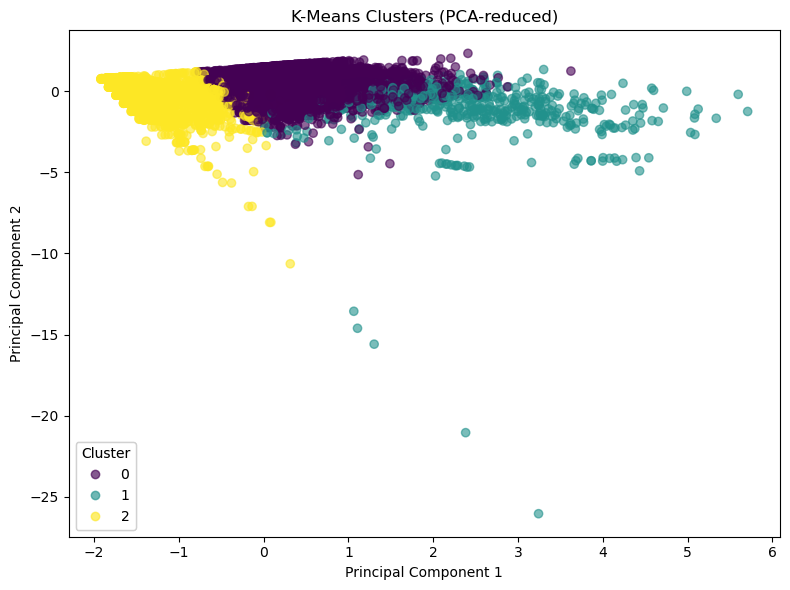

In [49]:
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(df["pc1"], df["pc2"], c=df["kmeans_cluster"], alpha=0.6)
legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend1)
ax.set_title("K-Means Clusters (PCA-reduced)")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
plt.tight_layout()
plt.show()

In [51]:
summary = (
    df.groupby("kmeans_cluster")
      .agg(count=("show_id", "count"),
           avg_duration=("duration_num", "mean"),
           dominant_type=("type", lambda x: x.mode().iat[0]),
           avg_release_year=("release_year", "mean"))
      .round(1)
)
print("\nK-Means Cluster Summary:\n", summary, "\n")


K-Means Cluster Summary:
                 count  avg_duration dominant_type  avg_release_year
kmeans_cluster                                                     
0                5252         101.7         Movie            2015.6
1                 596         108.8         Movie            1987.9
2                2956           5.4       TV Show            2017.1 



In [57]:
genre_cols = genre_labels
genre_dist = df.groupby("kmeans_cluster")[genre_cols].mean().round(2)
print("Genre prevalence by cluster (fraction of titles containing genre):\n", genre_dist)


Genre prevalence by cluster (fraction of titles containing genre):
                 Action & Adventure  Children & Family Movies  Comedies  \
kmeans_cluster                                                           
0                             0.13                      0.09      0.27   
1                             0.29                      0.08      0.32   
2                             0.00                      0.04      0.01   

                Crime TV Shows  Documentaries  Docuseries  Dramas  \
kmeans_cluster                                                      
0                         0.00           0.14        0.00    0.41   
1                         0.00           0.05        0.01    0.41   
2                         0.16           0.03        0.13    0.01   

                Independent Movies  International Movies  \
kmeans_cluster                                             
0                             0.14                  0.48   
1                             0.07 